In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import time
from collections import deque, namedtuple
import random
import gymnasium as gym
import numpy as np
import PIL.Image

import imageio
import base64
import IPython

# set the seed for the random number generator
random.seed(42)
torch.manual_seed(42)

In [2]:

GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update

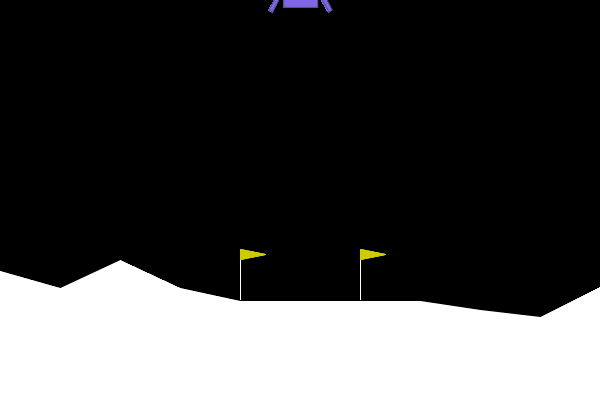

In [3]:
env = gym.make('LunarLander-v3', render_mode='rgb_array')
env.reset()
PIL.Image.fromarray(env.render())

In [4]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [5]:
# Reset the environment and get the initial state.
initial_state, _ = env.reset()
print(initial_state)

[ 3.7765501e-05  1.4222329e+00  3.8151830e-03  5.0278246e-01
 -3.7020091e-05 -8.6421927e-04  0.0000000e+00  0.0000000e+00]


In [6]:
# helper function to create and embed a video

def create_and_embed_video(env_name, q_network, episode, fps=30, max_steps_per_episode=1000):
    env = gym.make(env_name, render_mode='rgb_array')
    filename = f"{env_name}_episode_{episode}.mp4"

    def create_video(env, q_network, fps=30):
        with imageio.get_writer(filename, fps=fps) as video:
            done = False
            state, _ = env.reset()
            frame = env.render()
            video.append_data(frame)
            steps = 0   
            while not done and steps < max_steps_per_episode:
                steps += 1
                # Convert state to float32 numpy array before expanding dimensions
                state = np.array(state, dtype=np.float32)
                state = np.expand_dims(state, axis=0)
                state = torch.tensor(state, dtype=torch.float32)
                with torch.no_grad():  # Add this to prevent gradient computation
                    q_values = q_network(state)
                action = np.argmax(q_values.numpy()[0])
                state, reward, done, truncated, _ = env.step(action)
                frame = env.render()
                video.append_data(frame)

    def embed_mp4(filename):
        """Embeds an mp4 file in the notebook."""
        video = open(filename, 'rb').read()
        b64 = base64.b64encode(video)
        tag = '''
        <video width="840" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
        Your browser does not support the video tag.
        </video>'''.format(b64.decode())
        return IPython.display.HTML(tag)

    create_video(env, q_network, fps)
    return embed_mp4(filename)

Initial State: [0.000 1.422 0.004 0.503 -0.000 -0.001 0.000 0.000]
Action: 1
Next State: [0.000 1.433 -0.005 0.477 0.002 0.034 0.000 0.000]
Reward Received: 1.2795024608510357
Episode Terminated: False
Truncated: False
Info: {}


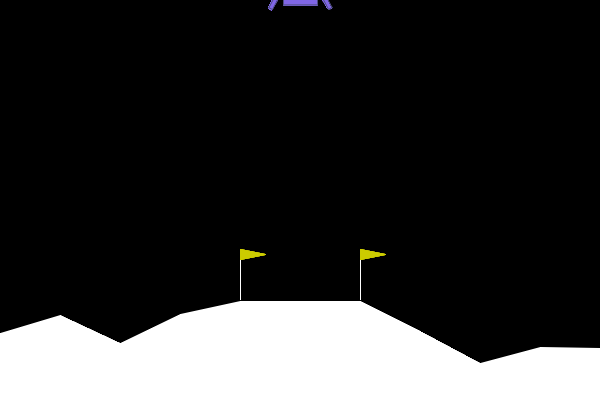

In [7]:
# Select an action
action = 1

# Run a single time step of the environment's dynamics with the given action.
new_state, reward, done, truncated, info = env.step(action)

with np.printoptions(formatter={'float': '{:.3f}'.format}):
    print("Initial State:", initial_state)
    print("Action:", action)
    print("Next State:", new_state)
    print("Reward Received:", reward)
    print("Episode Terminated:", done)
    print("Truncated:", truncated)
    print("Info:", info)
PIL.Image.fromarray(env.render())


## Build model

build a torch model:
* An `Input` layer that takes `state_size` as input.

* A `Dense` layer with `64` units and a `relu` activation function.

* A `Dense` layer with `64` units and a `relu` activation function.

* A `Dense` layer with `num_actions` units and a `linear` activation function. This will be the output layer of our network.

In [8]:
class Model(nn.Module):
    def __init__(self, state_size, num_actions):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(state_size[0], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, num_actions)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

policy_model = Model(state_size, num_actions)
optimizer = optim.Adam(policy_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# make a target model that is copied from the policy model
target_model = Model(state_size, num_actions)

# copy the weights from the policy model to the target model
target_model.load_state_dict(policy_model.state_dict())

print(policy_model)


Model(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


In [9]:
# Store experiences as named tuples
Experience = namedtuple("Experience", field_names=[
                        "state", "action", "reward", "next_state", "done"])


In [10]:
MEMORY_SIZE = 100_000     # size of memory buffer
# implement the experience replay buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

# create a replay buffer
replay_buffer = ReplayBuffer(capacity=MEMORY_SIZE)

# add a random experience to the buffer
replay_buffer.add(Experience(state=initial_state, action=action,
                             reward=reward, next_state=new_state, done=done))

In [11]:

# Define epsilon-greedy action selection
def select_action(state, model, epsilon=0.1):
    if random.random() < epsilon:
        return random.randint(0, num_actions-1)

    with torch.no_grad():
        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = model(state)
        return q_values.argmax().item()


# Define training function
def train_step(experiences, policy_model, target_model, optimizer, batch_size=64):
    # Sample random batch of experiences
    batch = random.sample(experiences, batch_size)

    # Convert batch of experiences to separate arrays - with optimization
    states = torch.FloatTensor(np.array([exp.state for exp in batch]))
    actions = torch.LongTensor([exp.action for exp in batch])
    rewards = torch.FloatTensor([exp.reward for exp in batch])
    next_states = torch.FloatTensor(
        np.array([exp.next_state for exp in batch]))
    dones = torch.FloatTensor([exp.done for exp in batch])

    # Compute current Q values
    current_q_values = policy_model(states).gather(1, actions.unsqueeze(1))

    # Compute next Q values
    with torch.no_grad():
        next_q_values = target_model(next_states).max(1)[0]

        # Compute target Q values
        target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))
        target_q_values = target_q_values.unsqueeze(1)

    # Compute loss
    loss = loss_fn(current_q_values, target_q_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


# Main training loop
num_episodes = 1000
batch_size = 64
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
max_steps_per_episode = 1000
epsilon = epsilon_start
acc_rewards = []
min_experiences = 200

for episode in range(num_episodes):
    state, _ = env.reset()
    acc_reward = 0
    done = False
    truncated = False
    steps = 0
    # Update target model once per two episodes
    if   episode % 2 == 0:
        target_model.load_state_dict(policy_model.state_dict())
    if episode == 0 or (episode + 1) % 100 == 0:
        video = create_and_embed_video(
            'LunarLander-v3', policy_model, episode=episode)
    while not (done or truncated) and steps < max_steps_per_episode:
        # Select action
        action = select_action(state, policy_model, epsilon)

        # Take action
        next_state, reward, done, truncated, _ = env.step(action)

        # Store experience
        experience = Experience(state, action, reward, next_state, done)
        replay_buffer.add(experience)

        # Update state and score
        state = next_state
        acc_reward += reward
        steps += 1
        # Train model if enough experiences are collected
        if len(replay_buffer.buffer) >= min_experiences:
            loss = train_step(replay_buffer.buffer, policy_model, target_model,
                              optimizer, batch_size)


    # Decay epsilon
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

    # Store accumulated reward
    acc_rewards.append(acc_reward)

    # Print progress
    if (episode + 1) % 10 == 0:
        avg_acc_reward = np.mean(acc_rewards[-10:])
        print(
            f"Episode {episode + 1}, Average accumulated reward: {avg_acc_reward:.2f}, Epsilon: {epsilon:.2f}")

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 10, Average accumulated reward: -95.94, Epsilon: 0.95
Episode 20, Average accumulated reward: -229.57, Epsilon: 0.90


KeyboardInterrupt: 

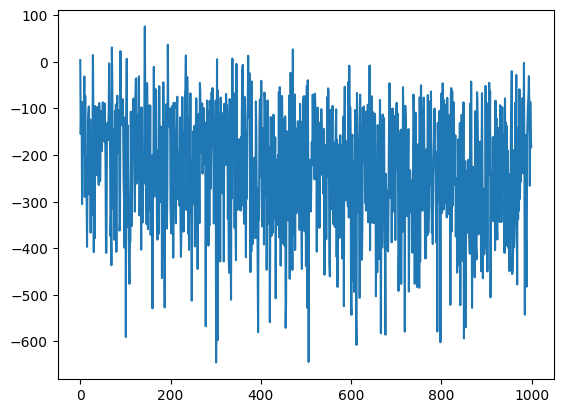

In [59]:
# plot the scores
import matplotlib.pyplot as plt
plt.plot(acc_rewards)
plt.show()
